# CNN - Slice Predictor

Here we develop a CNN that takes as input 2 slices of a brain image and predicts the centre slice. Note we only use b=0 intensity values

### Upload the data required

We use both scans of subjects 1-5 from the PETMR dataset for training.

We used the scan of subjects 6-7 also from the PETMR dataset for testing.

## FUNCTIONS

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [2]:
def get_data(petmr_path, test_data, training_data, numb_training_scans, numb_testing_scans):
    os.chdir(petmr_path)
    count = 0
    for direc in os.listdir(os.getcwd())[1:]:
        scan_image = nib.load(str(petmr_path) + "/" + str(direc) + "/Brain_Extracted.nii.gz")
        scan_data = scan_image.get_data()
        #get b=0 volumes only
        bvals_scan, bvecs_scan = read_bvals_bvecs(str(petmr_path) + "/" + str(direc) + "/NODDI.bval",\
                                                  str(petmr_path) + "/" + str(direc) + "/NODDI.bvec")
        gtab_scan = gradient_table(bvals_scan, bvecs_scan)
        s0s_scan = scan_data[:, :, :, gtab_scan.b0s_mask]
        
        if(count < numb_training_scans):
            #append this data to the list containing the training data
            training_data.append(s0s_scan)
        else:
            testing_data.append(s0s_scan)
        count += 1
        if(count == (numb_training_scans + numb_testing_scans)):
            break
    return (training_data, test_data)

In [68]:
#It is necessary to pad the data since each scan can be of a different size
#This helps with the normalisation of the volumes
#Also helps with training and testing because we can use batches (must be same dimensions)

#Note we do not pad the depth dimension as we will be using axial slice volumes
def pad_data(dataset):
    max_width = 0
    max_hight = 0
    
    #iterate through the scans and update the above stats
    for scan in dataset:
        (width, hight, depth, volume) = scan.shape
        if width > max_width:
            max_width = width
        if hight > max_hight:
            max_hight = hight
            
    #iterate throug the scans again and pad them based on the max stats
    for index, scan in enumerate(dataset):
        #get padding dimensions
        (width, hight, depth, volume) = scan.shape
        pad_width = max_width-width
        pad_hight = max_hight-hight
        
        pad_w_b = pad_width/2
        pad_w_a = pad_width-pad_w_b
        
        pad_h_b = pad_hight/2
        pad_h_a = pad_hight-pad_h_b
        
        padding = ((pad_w_b, pad_w_a), (pad_h_b, pad_h_a), (0,0), (0,0))
        aug_scan = np.pad(scan, padding, mode='constant', constant_values=0)
        dataset[index] = aug_scan
    return dataset

In [29]:
#This function appends to a list all sets of 3-adjacent slices from a scan.
#This is done for all volumes of a scan

#Note we can also calculate the mean and std of the data at this stage in prep for normalisatioin
def slicify(data_scan, slice_store_inputs, slice_store_targets):
    (x,y,z,v) = data_scan.shape
    for volume in range(v):
        for i in range(0,z,2):
            #check that there exists a slice above
            if(i+2 < z):
                slice_store_inputs.append(np.stack((data_scan[:, :, i, volume], data_scan[:, :, i+2, volume]), axis=2))
                slice_store_targets.append(data_scan[:, :, i+1, volume])
            else:
                break
        for i in range(1,z,2):
            #check that there exists a slice above
            if(i+2 < z):
                slice_store_inputs.append(np.stack((data_scan[:, :, i, volume], data_scan[:, :, i+2, volume]), axis=2))
                slice_store_targets.append(data_scan[:, :, i+1, volume])
            else:
                break
    return (slice_store_inputs ,slice_store_targets)


In [48]:
def normalise(dataset, mean=None, std=None):
    data_array = np.array(dataset)
    if mean==None and std==None:
        #This is the training data
        mean = np.mean(data_array)
        std = np.std(data_array)
    #normalise the data
    data_array = (data_array - mean)/std
    return (data_array, mean, std)

In [52]:
def vix_data(input_data, target_data, volume):
    plt.figure
    plt.figure(figsize=(8,8))
    plt.subplot(1, 3, 1).set_axis_off()
    plt.imshow(input_data[volume][:, :, 0].T, cmap='gray', origin='lower')
    plt.title("Lower")
    plt.subplot(1, 3, 2).set_axis_off()
    plt.imshow(target_data[volume][:,:].T, cmap='gray', origin='lower')
    plt.title("Target")
    plt.subplot(1, 3, 3).set_axis_off()
    plt.imshow(input_data[volume][:, :, 1].T, cmap='gray', origin='lower')
    plt.title("Upper")
    plt.show()

-------------------------------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------------------------------
---



#### Upload the data

In [66]:
#upload the data
petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data'
training_data = []
testing_data = []
(training_data, testing_data) = get_data(petmr_data_path, testing_data, training_data, 16, 4)
print ("Number of scans used for training: %d" % len(training_data))
print ("Number of scans used for testing: %d" % len(testing_data))

Number of scans used for training: 16
Number of scans used for testing: 4


#### Pad the data

In [69]:
training_data = pad_data(training_data)
testing_data = pad_data(testing_data)

#### Slice up the data (Axial slices)

In [70]:
training_slices_input = []
training_slices_target = []
testing_slices_input = []
testing_slices_target = []
for scan in training_data:
    (training_slices_input, training_slices_target) = slicify(scan, training_slices_input, training_slices_target)
for scan in testing_data:
    (testing_slices_input, testing_slices_target) = slicify(scan, testing_slices_input, testing_slices_target)

In [71]:
print ("Nember of training examples : %d" % len(training_slices_input))
print ("Nember of testing examples : %d" % len(testing_slices_input))

Nember of training examples : 9906
Nember of testing examples : 2444


#### Visualise the data

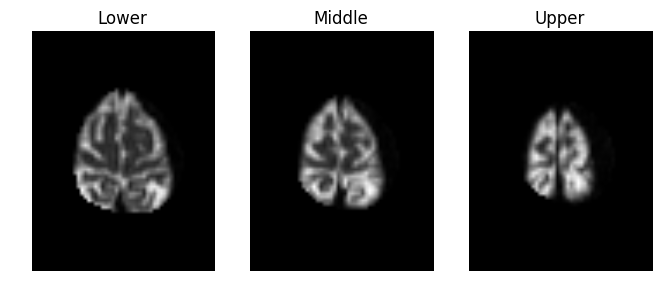

In [72]:
viz_data(training_slices_input, training_slices_target, 4089)

#### Normalise the training data inputs

In [73]:
#These are now numpy arrays
training_slices_input, mean, std = normalise(training_slices_input)
testing_slices_input, _, _ = normalise(testing_slices_input, mean, std)

In [89]:
training_slices_target = np.array(training_slices_target)
testing_slices_target = np.array(testing_slices_target)

## PYTORCH

In [94]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [105]:
#create a dataset class for our data

class MRIdataset(Dataset):
    """MRI b=0 dataset for axial slice volumes."""

    def __init__(self, input_slices, target_slices, transform=None):
        """
        Args:
            input_slices: Input slices
            target_slices: Corresponding target slice of the input slices
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.input_slices = input_slices
        self.target_slices = target_slices
        self.transform = transform

    def __len__(self):
        return self.input_slices.shape[0]

    def __getitem__(self, idx):
        input_slice = self.input_slices[idx]
        #Exapnd dims of target to make it have a depth of 1
        target_slice = np.expand_dims(self.target_slices[idx], 2)
        sample = {'input': input_slice, 'target': target_slice}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [106]:
class To_Tensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        inp, out = sample['input'], sample['target']
        
        #first expand dimension because torch expects H x W x D x C
        #currently we only have H x W x D
        aug_inp = np.expand_dims(inp, 3)
        aug_out = np.expand_dims(out, 3)

        # swap channel axis because
        # numpy: H x W x D x C
        # torch: C x D x H x W
        aug_inp = aug_inp.transpose((3, 2, 0, 1))
        aug_out = aug_out.transpose((3, 2, 0, 1))
        return {'input': torch.Tensor(aug_inp),
                'target': torch.Tensor(aug_out)}


### Upload the data using pytorch data loaders

In [107]:
training_dataset = MRIdataset(training_slices_input, training_slices_target, transform=transforms.Compose([To_Tensor()]))
testing_dataset = MRIdataset(testing_slices_input, testing_slices_target, transform=transforms.Compose([To_Tensor()]))

In [111]:
#Note: we keep a batch size of 1 due to inconsistent tensor sizes
trainloader = DataLoader(training_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
testloader = DataLoader(testing_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

## Develop CNN

Conv -> Relu -> Conv -> Relu -> Conv

--(WxHx2x1)--

conv1 = receptive field -> (3x3x3), zero padding -> 2,  number of filters -> 10

--(W+2xH+2x4x10)--

conv2 = receptive field -> (1x1x1), number of filters -> 15

--(W+2xH+2x4x15)--

conv3 = receptive field -> (3x3x3), number of filters -> 15

--(WxHx2x15)--

conv4 = receptive field -> (1x1x2), number of filters -> 1

--(WxHx1x1)--



## CONV NET 1

In [119]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 10, 3, padding=2)
        self.conv2 = nn.Conv3d(10, 15, 1)
        self.conv3 = nn.Conv3d(15, 15, 3)
        self.conv4 = nn.Conv3d(15, 1, (2,1,1), (2,1,1))


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return x


net = Net()
print(net)

Net (
  (conv1): Conv3d(1, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2))
  (conv2): Conv3d(10, 15, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv3): Conv3d(15, 15, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv4): Conv3d(15, 1, kernel_size=(2, 1, 1), stride=(2, 1, 1))
)


### NET 2

In [ ]:

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv3d(1, 5, 3, padding=2)
        self.conv2 = nn.Conv3d(5, 8, (2,1,1))
        self.conv3 = nn.Conv3d(8, 1, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x


net2 = Net2()
print(net2)

In [ ]:
import torch.optim as optim
#here we use MSE loss
criterion = nn.MSELoss(size_average=False) #returns the sum over a mini-batch as opposed to the average
optimizer = optim.SGD(net.parameters(), lr=0.00000001, momentum=0.9)


In [120]:
import torch.optim as optim
#here we use MSE loss
criterion = nn.MSELoss(size_average=False) #returns the sum over a mini-batch as opposed to the average
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [121]:
Adam_losses = []
Adam_acc = []

In [ ]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): #done in batches
        # get the inputs
        inputs = data['input']
        labels = data['target']

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize/update weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0] #loss is a variable tensor of size 1, we index to get the value out
        if i % 250 == 249:    # print every 2000 mini-batches
            print('[%d, %5d]' % (epoch + 1, i + 1))
    MSE_loss = running_loss / len(training_dataset)
    Adam_losses.append(MSE_loss)
    print('MSE Loss iteration %d = %.5f' % (epoch+1, MSE_loss ))
    '''   
    test_error = 0
    total = 0
    for test_data in testloader: #batch processing
        test_inputs = test_data['inp']
        test_labels = test_data['out']
        total += len(test_labels)
        
        test_outputs = net(Variable(test_inputs))
        
        test_error += (torch.nn.functional.mse_loss(test_outputs.data, test_labels, size_average=False)).data[0]
    
    test_error /= total
    print('MSE on test data: %f' % (test_error))
    Adam_acc.append(test_error)
    '''
print('Finished Training')

[1,   250]
[1,   500]
[1,   750]
[1,  1000]
[1,  1250]
[1,  1500]
[1,  1750]
[1,  2000]
[1,  2250]
MSE Loss iteration 1 = 24589665.19786
[2,   250]
[2,   500]
[2,   750]
[2,  1000]
[2,  1250]
[2,  1500]
[2,  1750]
[2,  2000]
[2,  2250]
MSE Loss iteration 2 = 19025105.51534
[3,   250]
[3,   500]
[3,   750]
[3,  1000]
[3,  1250]
[3,  1500]
[3,  1750]
[3,  2000]
[3,  2250]
MSE Loss iteration 3 = 18144150.49465
[4,   250]
[4,   500]
[4,   750]
[4,  1000]
[4,  1250]
[4,  1500]
[4,  1750]
[4,  2000]
[4,  2250]
MSE Loss iteration 4 = 17655023.96729
[5,   250]
[5,   500]
[5,   750]
[5,  1000]
[5,  1250]
[5,  1500]
[5,  1750]
[5,  2000]
[5,  2250]
MSE Loss iteration 5 = 17307795.90415
[6,   250]
[6,   500]
[6,   750]
[6,  1000]
[6,  1250]
[6,  1500]
[6,  1750]
[6,  2000]
[6,  2250]
MSE Loss iteration 6 = 17012143.87785
[7,   250]
[7,   500]
[7,   750]
[7,  1000]
[7,  1250]
[7,  1500]
[7,  1750]
[7,  2000]
[7,  2250]
MSE Loss iteration 7 = 16946009.21664
[8,   250]
[8,   500]
[8,   750]
[8,  100

#### Calculate the MSE on the testing dataset

In [ ]:
test_error = 0
total = 0
for test_data in testloader: #batch processing
    test_inputs = test_data['inp']
    test_labels = test_data['out']
    total += len(test_labels)
        
    test_outputs = net(Variable(test_inputs))
        
    test_error += (torch.nn.functional.mse_loss(test_outputs.data, test_labels, size_average=False)).data[0]
    
test_error /= total
print('MSE on test data: %f' % (test_error))

In [ ]:
for index, test_data in enumerate(testloader): #batch processing
        test_inputs = test_data['input']
        test_labels = test_data['target']
        
        test_outputs = net(Variable(test_inputs))
        predictions = test_outputs.data[0].numpy() 
        label = test_labels[0].numpy()
        inputs = test_inputs[0].numpy()
        
        #convert back to numpy dimensions of (HxWxD)
        prediction = prediction.transpose(2,3,1,0)
        label = label.transpose(2,3,1,0)
        inputs = inputs.transpose(2,3,1,0)
        
        #unnormalise the data
        prediction = (prediction * std) + mean
        label = (label * std) + mean
        inputs = (inputs * std) + mean
        
        prediction[prediction < 0] = 0
         
        predicted_slices.append(prediction[:,:,:,0])
        actual_slices.append(label[:,:,:,0])
        input_slices.append(inputs[:,:,:,0])

In [ ]:
plt.figure
plt.figure(figsize=(12,12))
plt.subplot(3, 3, 2).set_axis_off()
plt.imshow(input_slices[160][:, :, 1].T, cmap='gray', origin='lower')
plt.title("Above")
plt.subplot(3, 3, 4).set_axis_off()
plt.imshow(np.mean(input_slices[160], axis=2).T, cmap='gray', origin='lower')
plt.title("Average")
plt.subplot(3, 3, 5).set_axis_off()
plt.imshow(predicted_slices[1600][:, :, 0].T, cmap='gray', origin='lower')
plt.title("Predicted")
plt.subplot(3, 3, 6).set_axis_off()
plt.imshow(actual_slices[160][:, :, 0].T, cmap='gray', origin='lower')
plt.title("Actual")
plt.subplot(3, 3, 8).set_axis_off()
plt.imshow(input_slices[160][:, :, 0].T, cmap='gray', origin='lower')
plt.title("Below")
plt.show()